# **Ocean and Land Temperature Anomalies**

### Description
The project aims to analyze global temperature change over time through data visualization techniques. It involves gathering temperature anomalies data from diverse sources, processing, and cleaning it before employing various visualization methods. The objective is to provide insights into climate change trends and patterns, fostering understanding and urgency for sustainable practices and environmental supervision.

---
### **Team Members**

*   Saffian Asghar
*   Alexis Culpin
*   Romaric Sallustre
*   Emilio Espinosa S.

---

In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import urllib.request
from pathlib import Path
import matplotlib.animation as animation

### Constants and Functions

In [88]:
# Save URL into
NOAA_URL = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/1/12/1850-2023/data.json"
BERKLEY_URL = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Raw_TMAX_complete.txt"
HAD_CRUT5_URL = "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.csv"

# Daily RR (rain) -T( temperature)-Vent(wind) data for department 08, over the period 1871-1949
ardennes_RR_T_wind_1871_1949_url = "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_1871-1949_RR-T-Vent.csv.gz"
# Daily RR (rain) -T( temperature)-Vent(wind) data for department 08, over the period 1950 - 2022
ardennes_RR_T_wind_1950_2022_url = "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_latest-2023-2024_autres-parametres.csv.gz"
# Daily RR (rain) -T( temperature)-Vent(wind) data for department 08, over the period # Daily RR (rain) -T( temperature)-Vent(wind) data for department 08, over the period 1950 - 2023 - 2024
ardennes_RR_T_wind_2023_2024_url = "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_latest-2023-2024_RR-T-Vent.csv.gz"

# field description : https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_descriptif_champs_RR-T-Vent.csv

#### Function to get data if it doesn't exist

In [89]:
def save_data(urls, folder):
    subfolder = Path(f"./data/{folder}")
    subfolder.mkdir(parents=True, exist_ok=True)
    
    for key, url in urls.items():
        website_url = url.split("/")[2]
        file_extension = url.split(".")[-1]
        filepath = subfolder / f"{key}.{file_extension}"
        
        if not filepath.exists():
            urllib.request.urlretrieve(url, filepath)
            print(f"Data saved for {website_url} at {filepath}")
        else:
            print(f"Data already exists for {website_url} at {filepath}")

### Fetching global temperature data

In [90]:
urls = {"noaa_df" : NOAA_URL, "berkley_df" : BERKLEY_URL, "had_crut5_df" : HAD_CRUT5_URL}
# saving in a subfolder called global_temperature
save_data(urls, "global_temperature")

Data already exists for www.ncei.noaa.gov at data\global_temperature\noaa_df.json
Data already exists for berkeley-earth-temperature.s3.us-west-1.amazonaws.com at data\global_temperature\berkley_df.txt
Data already exists for www.metoffice.gov.uk at data\global_temperature\had_crut5_df.csv


In [91]:
subfolder = "./data/global_temperature/"

## Data Cleaning & Transformation


#### **NOAA dataset**

The dataset is hosted by NOAA's National Centers for Environmental Information (NCEI). It contains temperature anomaly data, representing deviations from a reference temperature over time. 

**Technical information**

* Data is collected from 1850 - 2023.
* The data is in JSON format.
* Columns of interest: year and data (yearly anomaly).

| Field        | Description                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| `DATE`  | Period of time in years.                                                                          |
| `DESCRIPTION`  | Description of data set itself.                                                                                       |
| `DATA`        | Anomaly in degrees Celsius.                                       |

**Data transformation required**
1. Read JSON.
2. Drop the description column.
3. Ensure every value within the date and data columns is numeric. The non-numeric values have to be drop.
4. Make sure the index (date) is an integer type value.
5. Rename data column to NOAAGlobalTemp and add the minimum and maximum years.

**Link**

* https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/1/12/1850-2023/data.json

**License**

Creative Commons Attribution 4.0 International license (CC-BY-4.0)


In [92]:
# Read Json file
df_noaa = pd.read_json("./data/global_temperature/noaa_df.json")

# Dataframe drop unnecessary columns ...
df_noaa = (
    df_noaa
    .drop('description', axis=1)
    .loc[pd.to_numeric(df_noaa.index, errors='coerce').notna()]
)
# Set index as int
df_noaa.index = df_noaa.index.astype(int)
# Rename columns with specific format
df_noaa = df_noaa.rename(columns=lambda x: f"NOAAGlobalTemp ({df_noaa.index.min()} - {df_noaa.index.max()})")
df_noaa.head()

,NOAAGlobalTemp (1850 - 2023)
1850,-0.06
1851,-0.08
1852,-0.01
1853,-0.12
1854,0.02


#### **CRUT5 dataset**

The dataset is derived from the Hadley Centre for Climate Science and Services at the UK Met Office, suggesting tabular data, possibly containing global monthly climate information. The dataset includes time series summaries for global climate analysis, incorporating columns with both upper and lower confidence limits.

**Technical information**

* Data collected from 1850 - 2023.
* The data is in CSV format.
* Columns of interest: year and anomaly in degrees celsius (temperature anomaly).

| Field        | Description                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| `YEAR_MONTH`  | Period of time in "YYYY-MM" format.                                                                      |
| `ANOMALY IN DEGREES CELSIUS`  | Monthly anomaly in degrees celsius.                                                                                   |
| `LOWER CONFIDENCE LIMIT (2.5%)`        | Numbers at the lower end of the confidence interval.                |
| `UPPER CONFIDENCE LIMIT (97.5%)`        | Numbers at the upper end of the confidence interval.                     |

**Data transformation required**
 1. Read a CSV file into a pandas DataFrame, parsing the 'Time' column as dates.
 2. Group the DataFrame by the year part of the 'Time' column.
 3. Calculate the mean of the 'Anomaly (deg C)' column for each year.
 4. Reset the DataFrame index.
 5. Set the 'Time' column as the new index.
 6. Convert the index values to integers.
 

**Link**

* https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.csv

**License**

Open Government License (OGL) for Public Sector Information.

In [93]:
# read second dataset
had_crut5_df = pd.read_csv('./data/global_temperature/had_crut5_df.csv', parse_dates=['Time'])
# Group by year and calculate average per year.
had_crut5_df = (
    had_crut5_df
    .groupby(had_crut5_df['Time'].dt.year)['Anomaly (deg C)'].mean().reset_index()
    .set_index('Time')
)
# Set index as int
had_crut5_df.index = had_crut5_df.index.astype(int)
had_crut5_df.head()

,Anomaly (deg C)
Time,
1850,-0.417711
1851,-0.233350
1852,-0.229399
1853,-0.270354
1854,-0.291521


#### **Berkley dataset**

The dataset is associated with the Berkeley Earth project, an independent climate science organization, the dataset focuses on the "Annual Anomaly" column. Housed on Amazon S3, the data contains raw maximum temperature (TMAX) data, reflecting the highest recorded temperatures.

**Technical information**

* Data collected from 1850 - 2023.
* The dataset has missing values in 2023.
* The data is in TXT format.
* Columns of interest: year and annual anomaly (difference of temperature from a base reference).

| Field        | Description                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| `YEAR`  | Period of time in years.                                                 |
| `MONTH`  | Period of time in months.                                                                          |
| `MONTHLY ANOMALY`        | Monthly anomaly in degrees celsius.                                     |
| `ANNUAL ANOMALY`        | Yearly anomaly in degrees celsius.               |
| `FIVE YEAR ANOMALY`        | 5 year rolling average anomaly in degrees celsius.               |
| `TEN YEAR ANOMALY`        | 10 year rolling average anomaly in degrees celsius.               |
| `TWENTY YEAR ANOMALY`        | 20 year rolling average anomaly in degrees celsius.           |

**Data transformation required**
 1. Read a space-delimited text file into a pandas DataFrame, ignoring lines that start with "%".
 2. Group the DataFrame by the 'year' column.
 3. Calculate the mean of the 'anomaly' column for each year.
 4. Reset the DataFrame index.
 5. Set the 'year' column as the new index.
 6. Convert the index values to integers.
 
**Link**

* https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Raw_TMAX_complete.txt

**License**

Creative Commons Attribution 4.0 International license (CC-BY-4.0)


In [94]:
# Read third dataset
berkley_df = pd.read_csv('./data/global_temperature/berkley_df.txt', comment="%", delim_whitespace=True, names= ["year", "month", "anomaly", "yearAvgAnomaly", "5yearAvgAnomaly", "10yearAvgAnomaly", "20yearAvgAnomaly"])
# Group by year and calculate average per year.
berkley_df = (
    berkley_df
    .groupby(berkley_df['year'])['anomaly'].mean().reset_index()
    .set_index('year')
)
# berkley_df = berkley_df.assign(realTemp = berkley_df['anomaly'] + 14.40)
berkley_df.index = berkley_df.index.astype(int)
berkley_df

C:\Users\baigs\AppData\Local\Temp\ipykernel_13340\1851333198.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  berkley_df = pd.read_csv('./data/global_temperature/berkley_df.txt', comment="%", delim_whitespace=True, names= ["year", "month", "anomaly", "yearAvgAnomaly", "5yearAvgAnomaly", "10yearAvgAnomaly", "20yearAvgAnomaly"])


,anomaly
year,
1850,-1.141667
1851,-0.971583
1852,-1.007917
1853,-0.382333
1854,-0.170500
...,...
2019,1.199167
2020,1.391000
2021,1.160500


In [95]:
# Join the two datasets based on the common 'index' (year)
merged_df = (
    df_noaa
    .join(had_crut5_df.rename(columns={'Anomaly (deg C)': 'HadCRUT5_Anomaly'}), how='left')
    .join(berkley_df.rename(columns={'anomaly':'Berkley_anomaly'}), how='left')
)

# Rename the new column as per your specified format
merged_df = (
    merged_df
    .rename(columns={'HadCRUT5_Anomaly': f"HAD_CRUT5 ({had_crut5_df.index.min()} - {had_crut5_df.index.max()})"})
    .rename(columns={'Berkley_anomaly': f"BerkleyEarth ({berkley_df.index.min()} - {berkley_df.index.max()})"})
)

In [96]:
merged_df

,NOAAGlobalTemp (1850 - 2023),HAD_CRUT5 (1850 - 2023),BerkleyEarth (1850 - 2023)
1850,-0.06,-0.417711,-1.141667
1851,-0.08,-0.233350,-0.971583
1852,-0.01,-0.229399,-1.007917
1853,-0.12,-0.270354,-0.382333
1854,0.02,-0.291521,-0.170500
...,...,...,...
2019,1.12,0.891073,1.199167
2020,0.83,0.922921,1.391000
2021,0.90,0.761906,1.160500
2022,0.83,0.801305,1.205750


<Axes: title={'center': 'Global Temperature change'}>

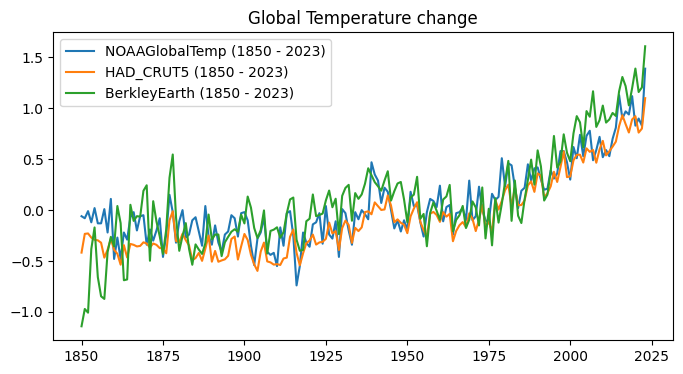

In [97]:

fig, ax = plt.subplots(figsize=(8, 4))

def animate(i):
    ax.clear()
    merged_df.iloc[:i].plot(kind='line', ax=ax, legend=False)
    ax.set_title('Global Temperature change')
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature Anomaly (°C)')

ani = animation.FuncAnimation(fig, animate, frames=len(merged_df), interval=5000)
plt.close(fig)
ani.save('global_temperature_change.gif', writer='pillow', fps=30)
merged_df.plot(kind='line', figsize=(8, 4), title='Global Temperature change')

#### **Météo France dataset**
Meteo Ardennes provides localized weather data for the Ardennes region, encompassing essential parameters like temperature, precipitation, and wind speed. Sourced from regional weather stations and collaborative efforts with meteorological agencies, the data offers valuable insights for informed decision-making. Available in CSV.GZ format, these compressed files store tabular weather information efficiently. The dataset contains climatological data from all French and overseas stations since their opening, for all available parameters. 

**Technical information**

* Daily data are available for download, by department and by period batch, in compressed csv format.
* All parameters are provided for all weather stations.
* Times are expressed in UTC for mainland France and in FU for overseas territories
* Files are updated annually for historical data prior to 1950, monthly for data from 1950 to year -2, and daily for the last two years.

| Field        | Description                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------|
| `NUM_POSTE`  | Météo-France station number on 8 digits                                                                          |
| `NOM_USUEL`  | Common name of the station                                                                                       |
| `LAT`        | Latitude, negative in the south (in degrees and millionths of a degree)                                          |
| `LON`        | Longitude, negative west of GREENWICH (in degrees and millionths of a degree)                                    |
| `ALTI`       | Altitude of the shelter base or rain gauge if no shelter (in meters)                                             |
| `AAAAMMJJ`   | Measurement date (year month day)                                                                                |
| `RR`         | Amount of precipitation fallen in 24 hours (from 06h UTC on day J to 06h UTC on day J+1). Value for day J is recorded at J+1 (in mm and tenths) |
| `TN`         | Minimum temperature under shelter (in °C and tenths)                                                             |
| `HTN`        | Time of TN (hhmm)                                                                                                |
| `TX`         | Maximum temperature under shelter (in °C and tenths)                                                             |
| `HTX`        | Time of TX (hhmm)                                                                                                |
| `TM`         | Daily average of hourly temperatures under shelter (in °C and tenths)                                            |
| `TNTXM`      | Daily average (TN+TX)/2 (in °C and tenths)                                                                       |
| `TAMPLI`     | Daily thermal amplitude: difference between daily TX and TN (TX-TN) (in °C and tenths)                           |
| `TNSOL`      | Daily minimum temperature 10 cm above ground (in °C and tenths)                                                  |
| `TN50`       | Daily minimum temperature 50 cm above ground (in °C and tenths)                                                  |
| `DG`         | Duration of frost under shelter (T ≤ 0°C) (in minutes)                                                           |
| `FFM`        | Daily average wind force averaged over 10 minutes, at 10 m (in m/s and tenths)                                   |
| `FF2M`       | Daily average wind force averaged over 10 minutes, at 2 m (in m/s and tenths)                                    |
| `FXY`        | Daily maximum of maximum hourly wind force averaged over 10 minutes, at 10 m (in m/s and tenths)                 |
| `DXY`        | Direction of FXY (in compass points of 360)                                                                      |
| `HXY`        | Time of FXY (hhmm)                                                                                               |
| `FXI`        | Daily maximum of maximum hourly instantaneous wind force, at 10 m (in m/s and tenths)                            |
| `DXI`        | Direction of FXI (in compass points of 360)                                                                      |
| `HXI`        | Time of FXI (hhmm)                                                                                               |
| `FXI2`       | Daily maximum of maximum hourly instantaneous wind force, at 2 m (in m/s and tenths)                             |
| `DXI2`       | Direction of FXI2 (in compass points of 360)                                                                     |
| `HXI2`       | Time of FXI2 (hhmm)                                                                                              |
| `FXI3S`      | Daily maximum of maximum hourly wind force averaged over 3 seconds, at 10 m (in m/s and tenths)                  |
| `DXI3S`      | Direction of FXI3S (in compass points of 360)                                                                    |
| `HXI3S`      | Time of FXI3S (hhmm)                                                                                             |

Quality codes associated with each data point (e.g., T;QT):
- `9`: Filtered data (the data has passed first-level filters/controls)
- `0`: Protected data (the data has been definitively validated by the climatologist)
- `1`: Validated data (the data has been validated by automatic control or by the climatologist)
- `2`: Doubtful data under review (the data has been questioned by automatic control)

**Link**

* https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_1871-1949_RR-T-Vent.csv.gz
* https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_latest-2023-2024_autres-parametres.csv.gz
* https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_08_latest-2023-2024_RR-T-Vent.csv.gz

**License** 

Etalab Open Licence 2.0.

In [98]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(ardennes_RR_T_wind_1871_1949_url, compression='gzip', sep=';')

# Display the DataFrame
df.head()




,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,DXI2,QDXI2,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S
0,8016001,AOUSTE,49.8,4.316667,204,18800601,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8016001,AOUSTE,49.8,4.316667,204,18800602,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8016001,AOUSTE,49.8,4.316667,204,18800603,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8016001,AOUSTE,49.8,4.316667,204,18800604,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8016001,AOUSTE,49.8,4.316667,204,18800605,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


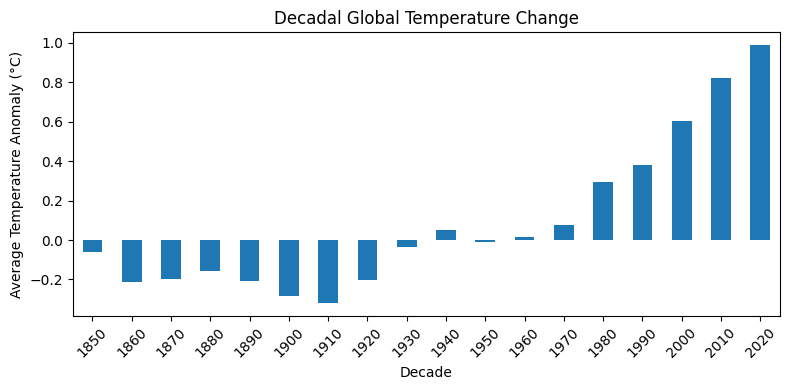

In [99]:

# Assuming the DataFrame has an index with years and a column named "NOAAGlobalTemp (1850 - 2023)"
# Extract the decade from the year
merged_df['Decade'] = merged_df.index // 10 * 10

# Calculate the decadal averages
decadal_averages = merged_df.groupby('Decade')['NOAAGlobalTemp (1850 - 2023)'].mean()

# Plot decadal temperature anomalies
fig, ax = plt.subplots(figsize=(8, 4))
decadal_averages.plot(kind='bar', ax=ax)
ax.set_title('Decadal Global Temperature Change')
ax.set_xlabel('Decade')
ax.set_ylabel('Average Temperature Anomaly (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\baigs\AppData\Local\Temp\ipykernel_13340\1167955524.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('seismic')


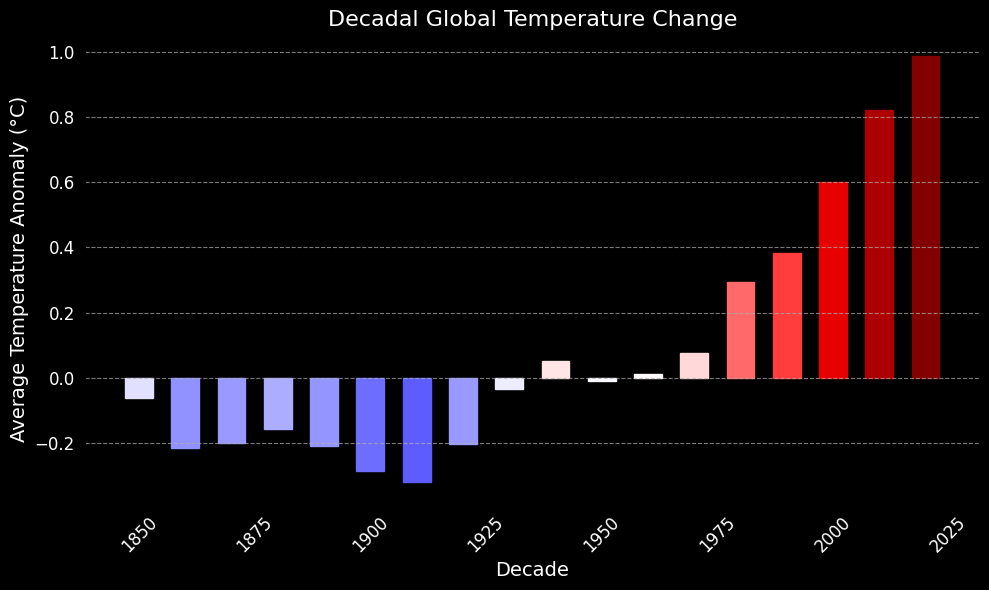

In [146]:
# Assuming the DataFrame has an index with years and a column named "NOAAGlobalTemp (1850 - 2023)"
# Extract the decade from the year
merged_df['Decade'] = merged_df.index // 10 * 10

# Calculate the decadal averages
decadal_averages = merged_df.groupby('Decade')['NOAAGlobalTemp (1850 - 2023)'].mean()

# Define the color map for the gradient
color_map = plt.cm.get_cmap('seismic')

# Plot decadal temperature anomalies with enhanced aesthetics
plt.figure(figsize=(10, 6), facecolor='black')
bars = plt.bar(decadal_averages.index, decadal_averages, edgecolor='gray', width=6)
# Set the color of each bar based on the y value
for bar, value in zip(bars, decadal_averages):
    color = color_map((value + 1) / 2)  # Normalize the value to range from 0 to 1
    bar.set_color(color)

plt.title('Decadal Global Temperature Change', fontsize=16, color='white')
plt.xlabel('Decade', fontsize=14, color='white')
plt.ylabel('Average Temperature Anomaly (°C)', fontsize=14, color='white')
plt.xticks(rotation=45, fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().set_facecolor('#000000')

plt.tight_layout()
plt.show()

In [102]:
df_12KTemp = pd.read_pickle("./data/Temp12k1_1_0.pkl")

In [103]:
type(df_12KTemp)

dict

In [104]:
df_12KTemp.head()

AttributeError: 'dict' object has no attribute 'head'

In [ ]:
import pickle

# Load the pickle file
with open('./data/Temp12k1_1_0.pkl', 'rb') as f:
    data = pickle.load(f)

# Inspect the loaded object
print(type(data))

<class 'dict'>


In [ ]:
sample_keys = list(data.keys())[:5]  # Adjust the number of keys you want to sample as needed

# Print out the sampled keys and their corresponding values
for key in sample_keys:
    print(key, type(data[key]))



D <class 'dict'>
TS <class 'list'>


In [ ]:
ts_list = data['TS']
print("First few elements in 'TS' list:")
for element in ts_list[:5]:  # Adjust the number of elements to display as needed
    print(element)

First few elements in 'TS' list:
{'mode': 'paleoData', 'time_id': 53.569659, 'archiveType': 'MarineSediment', 'createdBy': 'PalMod2LiPD', 'dataSetName': '117_723A.Godad.2011', 'lipdverseLink': 'http://lipdverse.org/Temp12k/1_0_2/117_723A.Godad.2011.html', 'maxYear': 22260, 'minYear': 500, 'nUniqueAges': 11, 'nUniqueOtherAges': 0, 'otherAgesPerKyr': '0', 'hasDepth': 1, 'nUniqueGoodAges': 11, 'agesPerKyr': 0.9565, 'lipdComplete': '100%', 'datasetId': 'tmeZsxjY5oSP1dOcgrJW', 'originalDataUrl': '10.1594/PANGAEA.775098,10.1594/PANGAEA.695217', 'changelog': [{'version': '1.0.5', 'lastVersion': '1.0.4', 'curator': 'nicholas', 'timestamp': '2022-05-18 00:24:16 UTC', 'changes': {'Paleo Column metadata': [["temperature (RL0SCEeYVWU): paleoData_mostRecentCompilations: '' has been replaced by 'Temp12k-1_0_2, HoloceneAbruptChange-0_10_0'"], ["temperature (RVwo44cKoew): paleoData_mostRecentCompilations: '' has been replaced by 'HoloceneAbruptChange-0_10_0'"]], 'Paleo Interpretation metadata': [["pla

In [ ]:
len(ts_list)

5203

In [117]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri